In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import re
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy
import matplotlib.pyplot as plt
import numpy as np
import logging
import multiprocessing
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalMaxPool1D, MaxPooling1D, Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

# Download data

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/Hackathon/'
wili_data_path = data_path + 'wili-2018/'

x_train_path = wili_data_path + 'x_train.txt'
x_test_path = wili_data_path + 'x_test.txt'
y_train_path = wili_data_path + 'y_train.txt'
y_test_path = wili_data_path + 'y_test.txt'
labels_path = wili_data_path + 'labels.csv'

In [0]:
# convert title of language in class
with open(y_train_path) as f:
    mylist = f.read().splitlines() 
languages = list(set(mylist))
language_to_class = dict()
class_to_language = dict()
for i in range(len(languages)):
    language_to_class[languages[i]] = i
    class_to_language[i] = languages[i]

In [8]:
print(list(language_to_class.items())[:5])
len(languages)

[('nep', 0), ('est', 1), ('vie', 2), ('pam', 3), ('csb', 4)]


235

In [0]:
def read_data():
    with open(x_train_path) as f:
        mylist = f.read().splitlines() 
    x_train = pd.DataFrame(mylist, columns=["sent"])
    with open(x_test_path) as f:
        mylist = f.read().splitlines() 
    x_test = pd.DataFrame(mylist, columns=["sent"])

    with open(y_train_path) as f:
        mylist = f.read().splitlines() 
    y_train = []
    for lan in mylist:
        y_train.append(language_to_class[lan])
    y_train = pd.DataFrame(y_train)
    with open(y_test_path) as f:
        mylist = f.read().splitlines()

    y_test = []
    for lan in mylist:
        y_test.append(language_to_class[lan])
    y_test = pd.DataFrame(y_test)
    
    return (x_train, y_train), (x_test, y_test)

In [0]:
(x_train, y_train), (x_test, y_test) = read_data()

In [11]:
print(x_train.head())
print(y_train.head())

print(x_train.shape)
print(x_test.shape)

                                                sent
0  Klement Gottwaldi surnukeha palsameeriti ning ...
1  Sebes, Joseph; Pereira Thomas (1961) (på eng)....
2  भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...
3  Après lo cort periòde d'establiment a Basilèa,...
4  ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...
     0
0    1
1  140
2  170
3  210
4   28
(117500, 1)
(117500, 1)


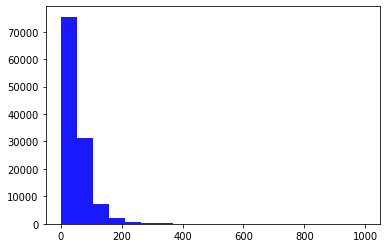

In [12]:
lens = x_train.sent.str.split(' ').str.len().values
plt.hist(lens, bins=np.linspace(0,1000,20), facecolor='blue', alpha=0.9)
plt.show()

# Experiment on small dataset

In [0]:
# small_dataset = pd.read_csv(data_path + 'kaggle_dataset/dataset.csv')
# small_dataset

In [0]:
# X=small_dataset['Text']
# y=small_dataset['language']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(len(X_train))
# print(len(X_test))
# print(len(y_train))
# print(len(y_test))

# Embedding **data**

In [0]:
filter_out = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890'
tokenizer = Tokenizer(filters=filter_out, lower=True)
tokenizer.fit_on_texts(x_train.sent)

Выбираю какое количество слов оставить. Если оставлять все, то будет 1500000, что слишком много. Можно поменять `count` и оно покажет сколько слов встречается больше, чем `count` раз

In [32]:
# try different values of `count`
# show how many words are presenting more than `count` times
count = 10
frequent_words = [w for w,c in tokenizer.word_counts.items() if c > count]
len(frequent_words)

64157

In [0]:
embed_size = 300 # how big is each word vector
max_features = len(frequent_words) # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200 # max number of words in a question to use

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters=filter_out, lower=True)

def prepare_data():
    x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1, stratify=y_train.values)
   
    tokenizer.fit_on_texts(x_tr.sent)

    train_X = tokenizer.texts_to_sequences(x_tr.sent)
    val_X = tokenizer.texts_to_sequences(x_val.sent)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    val_X = pad_sequences(val_X, maxlen=maxlen)

    return (train_X, y_tr), (val_X, y_val)
    

In [0]:
(train_X, train_Y), (val_X, val_Y) = prepare_data()

Проверила, что в тренировочном и валидационном датасетах встречаются все классы. Балансировка регулируется вот этим параметром: stratify=y_train.values

In [35]:
len(set(val_Y.values.reshape(1, -1)[0]))

235

In [0]:
len(set(train_Y.values.reshape(1, -1)[0]))

235

Ниже меняю представление векторов ответов из [1, 23, 10,...] в вектор длины 235 и с 1 на месте соответсвующего языка

In [59]:
lb = LabelEncoder()
y = lb.fit_transform(train_Y.values)
dummy_y_train = to_categorical(y)
print(len(dummy_y_train))
print(len(dummy_y_train[0]))

105750
235


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
y = lb.fit_transform(val_Y.values)
dummy_y_val = to_categorical(y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Metrics

In [0]:
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [0]:
def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [0]:
def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

#CNN

In [49]:
cnn_model = Sequential()
cnn_model.add(Embedding(max_features, embed_size,input_shape=(maxlen,)))
cnn_model.add(Conv1D(256, 5, activation='relu', input_shape=(embed_size,)))
cnn_model.add(MaxPooling1D(5))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(256, 5, activation='relu'))
cnn_model.add(MaxPooling1D(5))
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation="relu"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(len(languages), activation='softmax'))
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          19247100  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 196, 256)          384256    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 256)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 39, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 256)           327936    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 256)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1792)             

In [0]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1, recall, precision])

In [0]:
cnn_cp_path = data_path+'model_cnn.hdf5'
cnn_cp=ModelCheckpoint(cnn_cp_path, monitor='val_f1',save_best_only=True)

In [62]:
cnn_model.fit(train_X, dummy_y_train, batch_size=512, epochs=5, 
              validation_data=(val_X, dummy_y_val),
              callbacks = [cnn_cp])

Epoch 1/5
207/207 [==============================] - 87s 418ms/step - loss: 3.2681 - accuracy: 0.3020 - f1: 0.2766 - recall: 0.2162 - precision: 0.6018 - val_loss: 0.7261 - val_accuracy: 0.8397 - val_f1: 0.8468 - val_recall: 0.7590 - val_precision: 0.9581
Epoch 2/5
207/207 [==============================] - 86s 414ms/step - loss: 0.5337 - accuracy: 0.8660 - f1: 0.8820 - recall: 0.8239 - precision: 0.9495 - val_loss: 0.4821 - val_accuracy: 0.8918 - val_f1: 0.9104 - val_recall: 0.8615 - val_precision: 0.9651
Epoch 3/5
207/207 [==============================] - 85s 413ms/step - loss: 0.2602 - accuracy: 0.9291 - f1: 0.9427 - recall: 0.9112 - precision: 0.9765 - val_loss: 0.4964 - val_accuracy: 0.8921 - val_f1: 0.9114 - val_recall: 0.8736 - val_precision: 0.9528
Epoch 4/5
207/207 [==============================] - 86s 413ms/step - loss: 0.1830 - accuracy: 0.9478 - f1: 0.9589 - recall: 0.9353 - precision: 0.9838 - val_loss: 0.5692 - val_accuracy: 0.8871 - val_f1: 0.9085 - val_recall: 0.8762 

#RNN

In [63]:
rnn_model = Sequential()
rnn_model.add(Embedding(max_features, embed_size))
rnn_model.add(Bidirectional(LSTM(256, return_sequences=True, activation='tanh',input_dim=embed_size)))
rnn_model.add(Dropout(0.2))
rnn_model.add(Bidirectional(LSTM(256, return_sequences=True, activation='tanh')))
rnn_model.add(GlobalMaxPool1D())
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(512, activation="relu"))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(len(languages), activation='softmax'))
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         19247100  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 512)         1140736   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         1574912   
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)              

In [0]:
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1, recall, precision])

In [0]:
rnn_cp_path = data_path + 'model_rnn.hdf5'
rnn_cp=ModelCheckpoint(rnn_cp_path,monitor='val_f1',save_best_only=True)

In [66]:
rnn_model.fit(train_X, dummy_y_train, batch_size=512, epochs=3, 
              validation_data=(val_X, dummy_y_val), callbacks = [rnn_cp])

Epoch 1/3
207/207 [==============================] - 321s 2s/step - loss: 2.5891 - accuracy: 0.4243 - f1: 0.3768 - recall: 0.3188 - precision: 0.5763 - val_loss: 0.5165 - val_accuracy: 0.8675 - val_f1: 0.8854 - val_recall: 0.8305 - val_precision: 0.9481
Epoch 2/3
207/207 [==============================] - 317s 2s/step - loss: 0.4045 - accuracy: 0.8951 - f1: 0.9097 - recall: 0.8678 - precision: 0.9561 - val_loss: 0.3988 - val_accuracy: 0.8985 - val_f1: 0.9145 - val_recall: 0.8762 - val_precision: 0.9565
Epoch 3/3
207/207 [==============================] - 317s 2s/step - loss: 0.2285 - accuracy: 0.9368 - f1: 0.9492 - recall: 0.9225 - precision: 0.9775 - val_loss: 0.3939 - val_accuracy: 0.9061 - val_f1: 0.9226 - val_recall: 0.8887 - val_precision: 0.9592


# Results

In [0]:
x_test['sc'] = y_test

In [0]:
# Be careful! Tokenizer and maxlen is taken from train dataset from 1st part
def convert(x):
    train_X = tokenizer.texts_to_sequences(x.sent)
    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    return train_X

In [0]:
def metr(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return precision, recall, f1_val

# Test

In [88]:
ps = []
rs = []
fs = []
for lan in range(len(languages)):
    x_t = x_test[x_test['sc'] == lan]
    x = convert(x_t)
    y = np.zeros((x.shape[0], len(languages)))
    y[:, lan] = 1
    y = y.astype('float32')
    y_pred = cnn_model.predict(x)
    p, r, f = metr(y, y_pred)
    ps.append(p.numpy())
    rs.append(r.numpy())
    fs.append(f.numpy())
    print("language: ", class_to_language[lan], "precision: ", p.numpy(), "recall: ", r.numpy(), "f1: ", f.numpy())

language:  nep precision:  0.90123457 recall:  0.876 f1:  0.88843805
language:  est precision:  0.8597701 recall:  0.748 f1:  0.79999995
language:  vie precision:  0.98993963 recall:  0.984 f1:  0.9869609
language:  pam precision:  0.9605809 recall:  0.926 f1:  0.9429734
language:  csb precision:  0.9122449 recall:  0.894 f1:  0.9030303
language:  gle precision:  0.9816701 recall:  0.964 f1:  0.9727547
language:  ava precision:  0.8496732 recall:  0.78 f1:  0.8133471
language:  fra precision:  0.80131006 recall:  0.734 f1:  0.7661795
language:  zh-yue precision:  0.47887325 recall:  0.068 f1:  0.1190893
language:  msa precision:  0.8178054 recall:  0.79 f1:  0.80366224
language:  ext precision:  0.9414226 recall:  0.9 f1:  0.92024535
language:  bre precision:  0.9757576 recall:  0.966 f1:  0.97085416
language:  lad precision:  0.89979124 recall:  0.862 f1:  0.88049024
language:  snd precision:  0.99597585 recall:  0.99 f1:  0.9929789
language:  sin precision:  0.9627329 recall:  0.93 f

In [0]:
metrics = pd.DataFrame(
    {'precision': ps,
     'recall': rs,
     'f1': fs
    })

In [0]:
metrics = metrics.rename(class_to_language, axis='index')

In [80]:
print(metrics.head())

     precision  recall        f1
nep   0.918750   0.882  0.900000
est   0.917778   0.826  0.869474
vie   0.993976   0.990  0.991984
pam   0.956701   0.928  0.942132
csb   0.955375   0.942  0.948640


In [85]:
metrics[metrics.f1 < 0.7]

,precision,recall,f1
zh-yue,0.436620,0.062,0.108581
tha,0.967273,0.532,0.686452
zho,0.475000,0.038,0.070370
hbs,0.561674,0.510,0.534591
jpn,0.837838,0.124,0.216028
hrv,0.663793,0.616,0.639004
bod,0.963855,0.160,0.274442
lzh,0.000000,0.000,0.000000
khm,0.887029,0.424,0.573748
wuu,0.363636,0.032,0.058824


# Problems for jpn, lzh, zho, wuu (все метрики = 0)

In [0]:
x_train['sc'] = y_train

### jpg

In [72]:
language_to_class['jpn']

58

In [73]:
x_train[x_train['sc'] == 132]

,sent,sc
238,Lo' (Ingiriis: Cattle) waa xoolo gurijoog ah o...,132
370,Maxayeelay qofkasta oo wadanka ushaqeeya/uadee...,132
552,"tiu - kan, kaa; (ti- 'indikvorto' - fakufiiqe ...",132
912,Saldanada Warsengali waxaa la aasaasay dhamaad...,132
1550,"traduk/i - turjumid; traduko, tradukado, tradu...",132
...,...,...
116314,Xanuunkaas markuu qofka dareemo waxa uu u baah...,132
116323,"Xanuunkaan badanaa dilaa ma ahan, laakiin qofk...",132
116471,Waxa uu gudoomiye loogu doortay heshiisiinta b...,132
116496,"Quraan, Qur'aan, Quraanka Kariimka (carabi: ﺍﻟ...",132


### lzh

In [0]:
language_to_class['lzh']

32

In [0]:
x_train[x_train['sc'] == 32]

,sent,sc
336,武漢市，亦稱以漢，乃中華鄂省之會，亦為七大都市於中華之中原也。方八千四百六十七公里，於西元二...,32
420,按黃帝為法，數有十等。及其用也，乃有三焉。十等者，謂「億、兆、京、垓、秭、壤、溝、澗、正、載...,32
1254,范蠡浮海出齊，變姓名，自謂鴟夷子皮，耕於海畔，苦身戮力，父子治產。居無幾何，致產數千萬。齊人...,32
1414,周迪據臨川反，詔昭達便道征之。迪敗走，徵為護軍將軍，改封邵武縣侯。四年，陳寶應納迪，共寇臨川...,32
1549,喇克達長子敬德，康熙十一年(一六七二年)封三等奉恩將軍，四十七年(一七零八年)卒。敬德次子班...,32
...,...,...
116047,士族者，或曰門第、衣冠、世族、門閥、勢族、世家、巨室。蓋謂世居要位之高門也，世族所居不同，中...,32
116419,淳化二年秋七月，李繼遷請降，以爲銀州觀察使，賜姓名趙保吉。繼捧至夏州數月，即言繼遷悔過歸款，...,32
116596,孟嘗君怨秦，將以齊為韓、魏攻楚，因與韓、魏攻秦，而借兵食於西周。蘇代為西周謂曰：「君以齊為韓...,32
116749,陳敏之亂，弘以侃為江夏太守，加鷹揚將軍。侃備威儀，迎母官舍，鄉裡榮之。敏遣其弟恢來寇武昌，侃...,32


### zho

In [0]:
language_to_class['zho']

173

In [0]:
x_train[x_train['sc'] == 173]

,sent,sc
67,胡赛尼本人和小说的主人公阿米尔一样，都是出生在阿富汗首都喀布尔，少年时代便离开了这个国家。胡...,173
1042,2017年1月7日，參與了「SNH48第三屆年度金曲大賞BEST 50」。2月15日，出演由...,173
1127,在他们出发之前，罗伯特·菲茨罗伊送给了达尔文一卷查尔斯·赖尔所著《地质学原理》（在南美他得到...,173
1438,系列的第一款作品《薩爾達傳說》（ゼルダの伝説）在1986年2月21日於日本發行，之後在198...,173
2379,历史上的柔远驿是为了给琉球贡使及随员提供食宿之所，同时它也成为中琉间商业和文化交流的枢纽。琉...,173
...,...,...
116280,赛里木湖属于封闭型的断陷湖，是地壳下沉形成洼地，由四周的高山雪水历百万年慢慢汇聚而成。如今主...,173
116626,约瑟夫·维萨里奥诺维奇·泽·朱加什维利生于俄罗斯帝国哥里，毕业于梯弗里斯神学院。成为马克思主...,173
116788,和印度其他地方一样，板球也是孟买最为流行的一项运动。板球比赛通常在遍布全市的操场上进行。后院...,173
117051,1994年，邓斯特还与薇诺娜·瑞德和克萊兒·丹妮絲一起出演了同名原著改编的电影《小妇人》，该...,173


### wuu

In [0]:
language_to_class['wuu']

175

In [0]:
x_train[x_train['sc'] == 175]

,sent,sc
19,UNC有得一只历史悠久个'诚信守则'。渠是由学堂个诚信法庭（Honor Court）来执行个...,175
276,武器，是人类为达到杀伤或者防御个目的制造个器械。武器从人类文明发展开始就有出现，之后，伴随战...,175
387,弗过，太后个信任是一方面，具体西班牙个政治局面又是另外一番情形：贵族对迭个外国人一点也无信任...,175
720,从12世纪挨末阶段开始，日本个统治权就转移到日本武士贵族个手里向。到13世纪，出身清和源氏个...,175
930,箇种毛病潜伏期一般勒7日天以内，病人一般表现为流感箇浪个症状，像发寒热，咳嗽，少痰，有种辰光...,175
...,...,...
116805,Linux個低成本、強大個定制功能搭良好個移植性能，使得Linux來嵌入式系統方面也得到廣泛...,175
116947,余杭區勒拉杭嘉湖平原南端，西依天目山，南瀕錢塘江，是長江三角洲个圓心地。地理座標爲北緯30°...,175
117034,北師大是以京師大學堂師範專業做基礎，搭仔由北京個高校匯聚一批勒師範教育領域窮有聲望個名師組建...,175
117037,到清中期（約18世紀），傳奇開始衰微，向書齋文學轉化，彈詞卻逐步興盛起來了。出版之錢德蒼編个...,175


### Короче ГГ -- эти все языки с иероглифами :( Почекаем, что делает токенайзер:

In [0]:
x = x_train[x_train['sc'] == 132]
x

,sent,sc
29,エノが行きがかりでバスに乗ってしまい、気分が悪くなった際に助けるが、今すぐバスを降りたいと運...,132
46,シャーリー・フィールドは、サン・ベルナルド・アベニュー沿い市民センターとR&Tマーティン高校...,132
225,藤女の女性教師。48歳。数学担当。風紀指導を担当しており、リコにとっては天敵。藤女とその伝統...,132
339,教会旋法はまず終止音（finalis）によって4つに分類される。そしてそれぞれが音域（amb...,132
741,「MGR」という愛称で知られるM・G・ラーマチャンディランが、アンナードゥライの死後、ドラー...,132
...,...,...
116639,劉義隆が中郎将・荊州刺史となると、張邵はその下で司馬となり、南郡相を兼ねて、荊州の事務を決裁...,132
116901,紀元前334年にマケドニア王アレクサンドロス3世が小アジアに侵攻してきた時、アルサメスは他の...,132
117097,世間で「お嬢様学校」と呼ばれる名門校「私立藤崎女子中学」（略称：藤女）の生徒会執行部は、会長...,132
117135,実質的にはBRAVIA Phone U1とS002の後継にあたる2軸折りたたみ式の機種で今回...,132


In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x.sent)

In [0]:
# try different values of `count`
# show how many words are presenting more than `count` times
count = 10
low_count_words = [w for w,c in tokenizer.word_counts.items() if c > count]
len(low_count_words)

7

In [0]:
z = tokenizer.texts_to_sequences(x.sent)
z = pad_sequences(z, maxlen=maxlen)
z

array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0, 66416],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,  8504]], dtype=int32)

In [0]:
z

array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0, 66416],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,  8504]], dtype=int32)

# Короче мало слов, которые встречаются чаще 10 раз и у них какая-то другая модель языковая. Вот ниже пример для другого языка

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x.sent)

In [0]:
x = x_train[x_train['sc'] == 2]
x

,sent,sc
427,Pennsilfaanisch Deitsch iss gschwetzt in Yaako...,2
469,Der Freidaag iss der Friday. Er iss nooch Gris...,2
624,Der John M. Brenneman (1816-1895) waar en menn...,2
626,"Tobin, Jesse, 2008. Es Pennsylfaanisch Muunraa...",2
823,Two Dutchmen once got into a dispute about the...,2
...,...,...
115626,Der Johann Weber waar der Bruder vun em George...,2
116036,"Katharina Bärbel Bum, Die Sprache der Anzeigen...",2
116071,"Flughafe Ca Mau iss en Flughafe in Ca Mau, Pro...",2
116247,Der Donald Henry Pleasence (* 5. Oktower 1919 ...,2


In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x.sent)

In [0]:
# try different values of `count`
# show how many words are presenting more than `count` times
count = 10
low_count_words = [w for w,c in tokenizer.word_counts.items() if c > count]
len(low_count_words)

287

Я попробовала в токенайзере брать все слова и те, которые встречаются чаще 3 раз, а не 10. Нихера не помогает, просто модели не нравятся эти 4 языка от слова совсем. Видимо, эти блинских 4 языка устроены как-то совсем иначе и к ним не подойдет наш подход. Я бы просто вычеркнула их и забила, если не придумаем какую-то модель + токенайзер, которые все порешают

# Other chinese

Короче я нашла в перечне еще 2 китайских, на них все ок. Ну ты сам ниже увидишь почему

### hak

In [0]:
# hak

In [0]:
language_to_class['hak']

58

In [0]:
lan = 58
x_t = x_test[x_test['sc'] == lan]
x = convert(x_t)
y = np.zeros((x.shape[0], len(languages)))
y[:, lan] = 1
y = y.astype('float32')
y_pred = model.predict(x)
p, r, f = metr(y, y_pred)
print("language: ", class_to_language[lan], "precision: ", p.numpy(), "recall: ", r.numpy(), "f1: ", f.numpy())

language:  hak precision:  0.9936709 recall:  0.942 f1:  0.96714574


In [0]:
x_t

,sent,sc
64,"Tûng-sân Chhâ-theù (冬山車頭), yu hêm-cho Tûng-sân...",58
731,"1623-ngièn lòi-to Pet-kîn, chiông Ka-li-lio̍k ...",58
1000,Mâ-lòi-sî-â he Tûng-nàm-â koet-kâ chṳ̂-yit. Mâ...,58
1255,"Wal-Mart Kûng-sṳ̂ (Yîn-ngî： Wal-Mart Stores, I...",58
1862,Pat-pat suí-châi (八八水災) he 2009-ngièn pat-ngie...,58
...,...,...
115776,Tver (Ngò-ngî: Тверь) he Ngò-lò-sṳ̂ Tver-chû s...,58
116213,"1934-ngiàn pân Sin Po, yit-chak khiûn Chûng-fà...",58
117088,"Vò-é (禾仔, Ho̍k-miàng: Oryza sativa) he chhó-pú...",58
117152,Samba he Pâ-sî ke chhòn-thúng yîm-ngo̍k lâu th...,58


### nan

In [0]:
# nan

In [0]:
language_to_class['nan']

198

In [0]:
lan = 198
x_t = x_test[x_test['sc'] == lan]
x = convert(x_t)
y = np.zeros((x.shape[0], len(languages)))
y[:, lan] = 1
y = y.astype('float32')
y_pred = model.predict(x)
p, r, f = metr(y, y_pred)
print("language: ", class_to_language[lan], "precision: ", p.numpy(), "recall: ", r.numpy(), "f1: ", f.numpy())

language:  nan precision:  0.998 recall:  0.998 f1:  0.99799997


In [0]:
x_t

,sent,sc
9,"Tī Feigneux ê sì-ûi ū Béthancourt-en-Valois, C...",198
309,Tāi-sêng Hóe-chai Hái-siōng Pó-hiám Tu-sek Hōe...,198
719,"Só·-í, chí-iàu chai-iáⁿ chi̍t-khai-sí ê ūi-tì ...",198
855,"Tī Mossa ê sì-ûi ū Farra d'Isonzo, Gorizia, Sa...",198
1479,Bí-chiu ê chē-chē lâng kap chèng-tī jîn-bu̍t l...,198
...,...,...
115700,Chhùi-koà-kut (Lat: Os palatinum) sī thâu-koà-...,198
116223,"Tī Robbiate ê sì-ûi ū Calusco d'Adda, Imbersag...",198
116483,Chit phiⁿ bûn-chiuⁿ kài-siāu 1807 nî im-ga̍k l...,198
116590,"""Só͘-í lín m̄-thang kap in kāng-khóan; in-ūi l...",198


# Ниже еще чувааки из семейства Sino-Tibetan

### zh-yue

In [0]:
# zh-yue

In [0]:
language_to_class['zh-yue']

164

In [0]:
lan = 164
x_t = x_test[x_test['sc'] == lan]
x = convert(x_t)
y = np.zeros((x.shape[0], len(languages)))
y[:, lan] = 1
y = y.astype('float32')
y_pred = model.predict(x)
p, r, f = metr(y, y_pred)
print("language: ", class_to_language[lan], "precision: ", p.numpy(), "recall: ", r.numpy(), "f1: ", f.numpy())

language:  zh-yue precision:  0.0 recall:  0.0 f1:  0.0


In [0]:
x_t

,sent,sc
66,2008年3月31號至9月26號，逢星期一至五上晝6:40至6:45由東京電視台播出，共10...,164
87,1994年，喺朋友聚會上俾人用啤酒樽整傷左眼，從此左眼睇唔到嘢。後隨住事業嘅成功，佢喺22歲...,164
249,「1918年9月漢陽鐵廠技術人員名單」(華員)：制鋼股副股長楊卓，雲巖，江蘇上海，32歲，民...,164
596,唐傑忠自細就開始表演相聲，1949年參軍做部隊文工團團員後參加過好多場表演藝術。1964年調...,164
690,廣東省第二中醫院（粵拼：gwong2 dung1 saang2 dai6 ji6 zung1...,164
...,...,...
115401,荷蘭人同西班牙人喺東亞勾心鬥角，荷蘭人喺日本話西班牙企圖顛覆日本政府，引起日本鎖國，只准同中...,164
115567,粵語代表作有：《明日話今天》《春雨弯刀》《奮鬥》《東方之珠》《無敵是愛》《命運》《心曲》《播...,164
116797,比賽時間10分鐘，時間到空杯多為勝。 但空杯少方有最後投球權，最後比賽結束。 最後投球時可有...,164
117081,華僑將領胡文虎喺1931年返到中國內地之後，搵咗海珠石附近嘅長堤地區起咗間樓做工廠，直到19...,164


О да, нашла еще одного братюню к ним

### new

In [0]:
# new

In [0]:
language_to_class['new']

71

In [0]:
lan = 71
x_t = x_test[x_test['sc'] == lan]
x = convert(x_t)
y = np.zeros((x.shape[0], len(languages)))
y[:, lan] = 1
y = y.astype('float32')
y_pred = model.predict(x)
p, r, f = metr(y, y_pred)
print("language: ", class_to_language[lan], "precision: ", p.numpy(), "recall: ", r.numpy(), "f1: ", f.numpy())

language:  new precision:  0.9918033 recall:  0.968 f1:  0.979757


In [0]:
x_t

,sent,sc
237,थ्व थाय्‌ भारतया उत्तराखण्ड राज्यया कुमाँउ मण्...,71
315,भाषिक रुपय् थ्व थासय्‌ भारोपेली भाषा परिवारया ...,71
458,थ्व गां दूगु थाय्‌ थी-थी कालय् विभिन्न जुजुतये...,71
827,थ्व शहरयागु अक्षांश ३९.१२८९५२ उत्तर व देशान्तर...,71
947,थ्व थाय्‌ पौराणिक काल निसें हिन्दू धर्मया ग्रन...,71
...,...,...
116312,हिन्दू धर्मया ग्रन्थय् थ्व थाय् दूगु थाय्यात न...,71
116977,थ्व थाय्‌या अर्थतन्त्रय् बुंज्याया तःधंगु ल्हा...,71
117124,पञ्जाबी भाषा छ्गु भाषा खः। थ्व भाय् भारत व पाक...,71
117368,थ्व थाय्‌ भारतया उत्तराखण्ड राज्यया गढवाल मण्ड...,71


### mya

In [0]:
# mya

In [0]:
language_to_class['mya']

114

In [0]:
lan = 114
x_t = x_test[x_test['sc'] == lan]
x = convert(x_t)
y = np.zeros((x.shape[0], len(languages)))
y[:, lan] = 1
y = y.astype('float32')
y_pred = model.predict(x)
p, r, f = metr(y, y_pred)
print("language: ", class_to_language[lan], "precision: ", p.numpy(), "recall: ", r.numpy(), "f1: ", f.numpy())

language:  mya precision:  0.984252 recall:  0.75 f1:  0.8513053


In [0]:
x_t

,sent,sc
24,၂၀၁ဝ မတ် Forbes စာရင်းအရ သူ၏ကြွယ်ဝချမ်းသာမှုမှ...,114
379,က‌ဆုန်လပြည့်နေ့တွင် မြတ်ဗုဒ္ဓ၏ အဖြစ်တော်လေးမျိ...,114
914,သပိတ်ကံဆောင်မှုကို ဘုရားရှင် လက်ထက်က တကြိမ်၊ သ...,114
1296,ပထမ ၃ မျိုးမှာ လက္ခဏာများကိုလိုက်၍ ခေါ်ဝေါ်ခြင...,114
1383,ဟိတ်မြို့သည် မြောက်ပင်လယ် ကမ်းခြေမှ နှစ်မိုင် ...,114
...,...,...
116508,၁၉၄၅ - ဂျာနယ်ကျော်- ဩဂုတ်လထုတ်တွင် အခုရေစက်ဝတ္...,114
116562,Actinium အား ယူရေနီယမ် သတ္ထုရိုင်းများ ထဲတွင် ...,114
116989,"""ငါ့သမီးတော့ ဒီရန်သူရဲ့လက်အောက်မှာ အခိုင်းအစေ ...",114
117210,ယောမင်းကြီး ဦးဘိုးလှိုင် ဟုခေါ်သော ယောအတွင်းဝန...,114


### cdo

In [0]:
# cdo

In [0]:
language_to_class['cdo']

229

In [0]:
lan = 229
x_t = x_test[x_test['sc'] == lan]
x = convert(x_t)
y = np.zeros((x.shape[0], len(languages)))
y[:, lan] = 1
y = y.astype('float32')
y_pred = model.predict(x)
p, r, f = metr(y, y_pred)
print("language: ", class_to_language[lan], "precision: ", p.numpy(), "recall: ", r.numpy(), "f1: ", f.numpy())

language:  cdo precision:  0.99788135 recall:  0.942 f1:  0.96913576


In [0]:
x_t

,sent,sc
681,Huá-hŏk nguòng-só (化學元素) sê cī sié-gái dâi-dŏn...,229
772,YouTube sê siŏh ciáh ké̤ṳk nè̤ng hŭng-hiōng di...,229
905,"Găk gĭ-dók-gáu gì ùng-huá diē-sié, siông-dá̤ d...",229
1061,Wikisource (Wiki Dù-cṳ̆-guāng) sê Wikimedia gì...,229
1232,Gô-dā̤ (舊底) sê siŏh ciáh tiŭ-chiông gì sì-găng...,229
...,...,...
116150,Uòng-dô̤ Sĕk-nê Sĭng-cô̤ sê uòng-dô̤ gà̤-dēng ...,229
116286,Hĕ̤ng-ngṳ̀ (魟魚) sê náe̤ng-gáuk-ngṳ̀ gŏng diē-s...,229
116545,"Iù-tái-gáu, Gĭ-dók-gáu gâe̤ng Ĭ-sṳ̆-làng-gáu d...",229
116600,"Lìng Sié-gŭng diŏh Giū-mī-chŏng chók-sĕng, ĭ s...",229


### bod

In [0]:
# zh-yue

In [0]:
language_to_class['bod']

53

In [0]:
lan = 53
x_t = x_test[x_test['sc'] == lan]
x = convert(x_t)
y = np.zeros((x.shape[0], len(languages)))
y[:, lan] = 1
y = y.astype('float32')
y_pred = model.predict(x)
p, r, f = metr(y, y_pred)
print("language: ", class_to_language[lan], "precision: ", p.numpy(), "recall: ", r.numpy(), "f1: ", f.numpy())

language:  bod precision:  0.95862067 recall:  0.278 f1:  0.4310077


In [0]:
x_t

,sent,sc
133,(༡) ཐེག་པ་ཆེན་པོའི་ལུགས་ཀྱི་ཞིང་ཁམས་ཀྱི་རྣམ་གཞ...,53
148,༡༩༤༢ ལོ་ནས་བཟུང་བོད་ཀྱི་ལོ་རྒྱུས་ལ་སྤྲོ་བ་རྒྱས...,53
339,ལུགས་རྙིང་བོད་བཀའ་ཤག་སྲིད་གཞུང་གི་དམག་སྤྱི་ཆེན...,53
633,གྲོགས་པོ་ལ་ཕུལ་བ། རིང་ནས་འགྲོགས་པའི་ཉེ་བའི་གྲོ...,53
834,ལུ་ཡི་སེ་མི་ཤེལ་(ཧྥ་རན་སིའི་སྐད།: Louise Miche...,53
...,...,...
117009,སེམས་ཀྱི་རྨ་ཁའི་ན་ཟུག་ཁོག་ན་བཅུམ།། དགའ་སྐྱོ་བས...,53
117217,གནད་དོན་འདིས་མེན་ཌི་ལི་ཧྤེ་ཡི་དུས་འཁོར་རེའུ་མི...,53
117226,༁ྃ༔ ཟབ་ཆོས་ཞི་ཁྲོ་དགོངས་པ་རང་གྲོལ་ལས། བསྐྱེད་ར...,53
117242,སྐྲ། སྤུ། སེན་མོ། སོ། དྲི་མ། པགས་པ། ཤ། རུས་པ། ...,53
